In [19]:
import pandas as pd

In [20]:
df=pd.read_csv('/content/merged_hourly_load_weather.csv')

In [21]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [22]:
df.head()

,load,temperature_2m,relative_humidity_2m,precipitation,windspeed_10m,winddirection_10m,cloudcover,pressure_msl,dew_point_2m
datetime,,,,,,,,,
2018-01-01 00:00:00,1742.110000,11.8,76,0.0,3.7,281,0,1014.5,7.7
2018-01-01 01:00:00,1568.937500,9.0,86,0.0,4.8,257,0,1014.5,6.8
2018-01-01 02:00:00,1468.707500,8.1,87,0.0,6.5,264,0,1013.8,6.1
2018-01-01 03:00:00,1424.403333,7.9,87,0.0,7.9,267,0,1013.4,5.9
2018-01-01 04:00:00,1471.805000,8.1,85,0.0,6.1,273,0,1013.3,5.8


In [23]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df["day_of_month"] = df.index.day
df["day_of_year"] = df.index.day_of_year
df["year"] = df.index.year
df["week_of_year"] = df.index.isocalendar().week.astype("int64")
df.head()

,load,temperature_2m,relative_humidity_2m,precipitation,windspeed_10m,winddirection_10m,cloudcover,pressure_msl,dew_point_2m,hour,dayofweek,month,day_of_month,day_of_year,year,week_of_year
datetime,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1742.110000,11.8,76,0.0,3.7,281,0,1014.5,7.7,0,0,1,1,1,2018,1
2018-01-01 01:00:00,1568.937500,9.0,86,0.0,4.8,257,0,1014.5,6.8,1,0,1,1,1,2018,1
2018-01-01 02:00:00,1468.707500,8.1,87,0.0,6.5,264,0,1013.8,6.1,2,0,1,1,1,2018,1
2018-01-01 03:00:00,1424.403333,7.9,87,0.0,7.9,267,0,1013.4,5.9,3,0,1,1,1,2018,1
2018-01-01 04:00:00,1471.805000,8.1,85,0.0,6.1,273,0,1013.3,5.8,4,0,1,1,1,2018,1


In [24]:
!pip install tensorflow

In [25]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
threshold_date_1 = "01-01-2024"
threshold_date_2 = "01-01-2025"

In [27]:
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

## Feature Selection

In [28]:
FEATURES = ["hour", "day_of_month", "dayofweek", "day_of_year", "month", "year", "week_of_year", "temperature_2m", "relative_humidity_2m",	"windspeed_10m", "dew_point_2m"]
TARGET = "load"
FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train_keras = train_data_keras_s[:, :-1].reshape(train_data_keras_s.shape[0], 1, len(FEATURES))
y_train_keras = train_data_keras_s[:, -1]
X_test_keras = test_data_keras_s[:, :-1].reshape(test_data_keras_s.shape[0], 1, len(FEATURES))
y_test_keras = test_data_keras_s[:, -1]

### LSTM Model

In [29]:
# Train initial LSTM model
model = Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# Print the model summary to check the structure
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       274,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,689 (1.05 MB)

 Trainable params: 274,689 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, mode='min')
model_checkpoint = ModelCheckpoint('delhilstm_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=0,
    mode='min'
)
model.fit(X_train_keras, y_train_keras, epochs=100, batch_size=144, validation_data=(X_test_keras, y_test_keras), callbacks=[early_stopping, model_checkpoint, reduce_lr_loss])

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1351 - val_loss: 0.1267 - learning_rate: 0.0010
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0983 - val_loss: 0.1184 - learning_rate: 0.0010
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0978 - val_loss: 0.1276 - learning_rate: 0.0010
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0964 - val_loss: 0.1192 - learning_rate: 0.0010
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0949 - val_loss: 0.1162 - learning_rate: 0.0010
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0944 - val_loss: 0.1171 - learning_rate: 0.0010
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0928 - val_loss: 0.1083 - learning_rate: 0.0010
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0916 - val_loss: 0.1048 - learning_rate: 0.0010
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0909 - val_loss: 0.1026 - learning_rate: 0.0010


### LSTM Model Prediction

In [31]:
# Evaluate and save metrics for initial LSTM
pred_lstm = model.predict(X_test_keras)
results_lstm = test_data_keras_s.copy()
results_lstm[:, -1] = pred_lstm.reshape(-1)
results_lstm = scaler.inverse_transform(results_lstm)
result_frame_lstm = pd.DataFrame(index=test_data.index)
result_frame_lstm["load"] = test_data["load"]
result_frame_lstm["pred_lstm"] = results_lstm[:, -1]
mape_lstm = np.mean(np.abs((result_frame_lstm["load"] - result_frame_lstm["pred_lstm"]) / result_frame_lstm["load"])) * 100
rmse_lstm = np.sqrt(np.mean(np.square(result_frame_lstm["load"] - result_frame_lstm["pred_lstm"])))

print(f"MAPE of Initial LSTM Model: {mape_lstm:.2f}%")
print(f"RMSE of Initial LSTM Model: {rmse_lstm:.2f} MW")

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAPE of Initial LSTM Model: 10.47%
RMSE of Initial LSTM Model: 507.98 MW


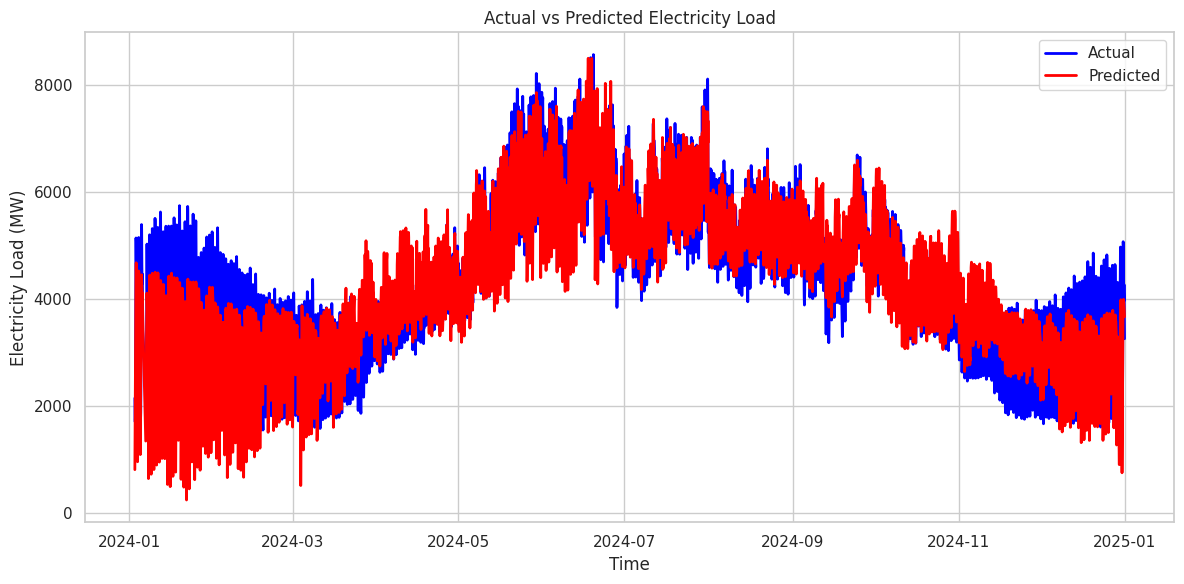

In [32]:
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt

# Set general plot aesthetics
sns.set(style="whitegrid")
rcParams['figure.figsize'] = 12, 6

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Actual vs Predicted using seaborn styling
ax.plot(result_frame_lstm.index, result_frame_lstm['load'], label='Actual', color='blue', linewidth=2)
ax.plot(result_frame_lstm.index, result_frame_lstm['pred_lstm'], label='Predicted', color='red', linewidth=2)

# Customize axes
ax.set_xlabel("Time")
ax.set_ylabel("Electricity Load (MW)")
ax.set_title("Actual vs Predicted Electricity Load")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

### Deep LSTM Model

In [33]:
# Define the deep LSTM model
model = Sequential()

# First LSTM layer with 50 units and return sequences for the next LSTM layer
model.add(LSTM(units=256, activation='tanh', input_shape=(X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences=True))
model.add(Dropout(0.5))  # Dropout to avoid overfitting

# Second LSTM layer with 50 units
model.add(LSTM(units=128, activation='tanh', return_sequences=True))
model.add(Dropout(0.5))  # Dropout to avoid overfitting

# Third LSTM layer with 50 units
model.add(LSTM(units=32, activation='tanh', return_sequences=False))  # Last LSTM layer, return_sequences=False
model.add(Dropout(0.5))  # Dropout to avoid overfitting

# Fully connected layer to output the predicted load
model.add(Dense(units=1))  # Output layer with 1 neuron (regression)

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Print the model summary
model.summary()

# Train the model
model.fit(X_train_keras, y_train_keras, epochs=100, batch_size=144, validation_data=(X_test_keras, y_test_keras),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr_loss])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 256)         │       274,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 492,193 (1.88 MB)

 Trainable params: 492,193 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1686 - val_loss: 0.1227 - learning_rate: 0.0010
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1069 - val_loss: 0.1339 - learning_rate: 0.0010
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0998 - val_loss: 0.1118 - learning_rate: 0.0010
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0953 - val_loss: 0.1132 - learning_rate: 0.0010
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0920 - val_loss: 0.1028 - learning_rate: 0.0010
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0888 - val_loss: 0.0902 - learning_rate: 0.0010
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0842 - val_loss: 0.0953 - learning_rate: 0.0010
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0806 - val_loss: 0.0760 - learning_rate: 0.0010
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0767 - val_loss: 0.0738 - learning_rate: 0.0010
E

### Deep LSTM Model Prediction

In [34]:
# Evaluate and save metrics for initial LSTM
pred_lstm = model.predict(X_test_keras)
results_lstm = test_data_keras_s.copy()
results_lstm[:, -1] = pred_lstm.reshape(-1)
results_lstm = scaler.inverse_transform(results_lstm)
result_frame_lstm = pd.DataFrame(index=test_data.index)
result_frame_lstm["load"] = test_data["load"]
result_frame_lstm["pred_lstm"] = results_lstm[:, -1]
mape_lstm = np.mean(np.abs((result_frame_lstm["load"] - result_frame_lstm["pred_lstm"]) / result_frame_lstm["load"])) * 100
rmse_lstm = np.sqrt(np.mean(np.square(result_frame_lstm["load"] - result_frame_lstm["pred_lstm"])))

print(f"MAPE of Initial LSTM Model: {mape_lstm:.2f}%")
print(f"RMSE of Initial LSTM Model: {rmse_lstm:.2f} MW")

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAPE of Initial LSTM Model: 8.47%
RMSE of Initial LSTM Model: 470.76 MW


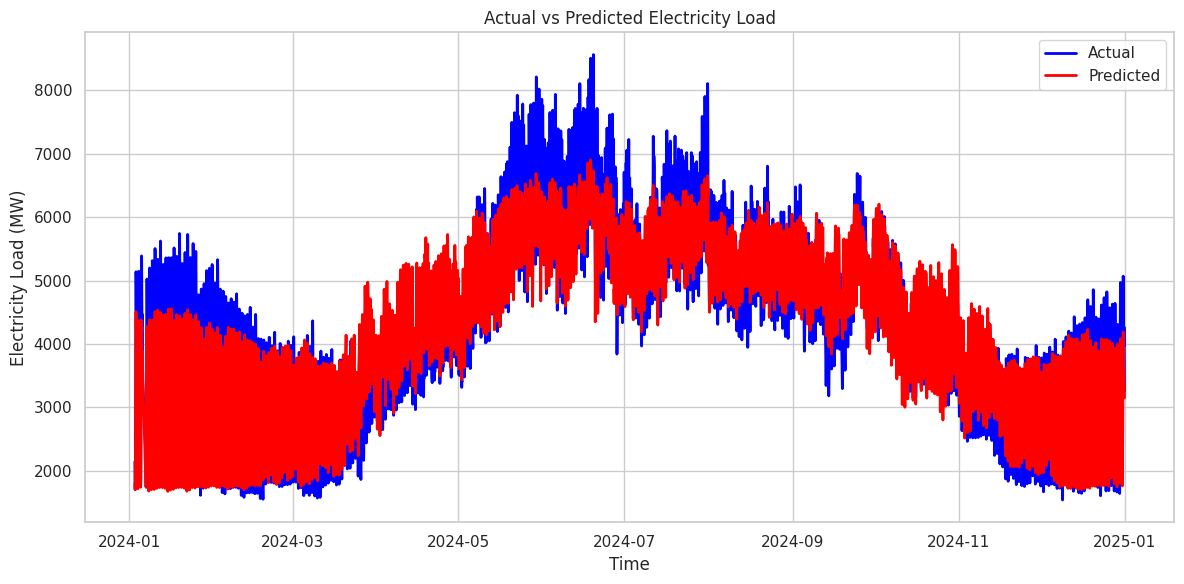

In [35]:
# Set general plot aesthetics
sns.set(style="whitegrid")
rcParams['figure.figsize'] = 12, 6

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Actual vs Predicted using seaborn styling
ax.plot(result_frame_lstm.index, result_frame_lstm['load'], label='Actual', color='blue', linewidth=2)
ax.plot(result_frame_lstm.index, result_frame_lstm['pred_lstm'], label='Predicted', color='red', linewidth=2)

# Customize axes
ax.set_xlabel("Time")
ax.set_ylabel("Electricity Load (MW)")
ax.set_title("Actual vs Predicted Electricity Load")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [36]:
model.save("deeplstm.keras")